In [1]:
import scanpy as sc

import sys
sys.path.append("../")

## Example 3: Infer Copy Number Variation

In [2]:
import echidna as ec
ec.pl.activate_plot_settings()

The following file contains data from a previous training run. The functions in this tutorial will rely on the model saves referenced in this file to perform learning and inference of CNV. See the first tutorial for further details.

In [3]:
adata = sc.read_h5ad("data/R310_MT_SAVE.h5ad")

To infer copy number variation, Echinda relies on positional information of genes on cytobands with a Gaussian Hidden Markov Model. In the default setting, Echinda calls a pre-configured genome with mappings of genes to bands using the UCSC hg38 database. Later in the tutorial, we will see guidelines for use of your own genome and the available hyperparameters.

In [4]:
ec.tl.infer_cnv(adata)

2024-10-19 05:13:32,388 | INFO : `genome` not set, defaulting to hg38cytoBands and wgEncodeGencodeCompV46.
2024-10-19 05:16:09,484 | INFO : Added `.uns['echidna']['save_data']['infer_cnv']` : Path to CNV inference results.
Added `.uns['echidna']['save_data']['gmm_neutrals']` : Path to Echidna cluster neutral value results.


Plot amplifications (red), deletions (blue), and no change (gray) in bands for a given cluster:

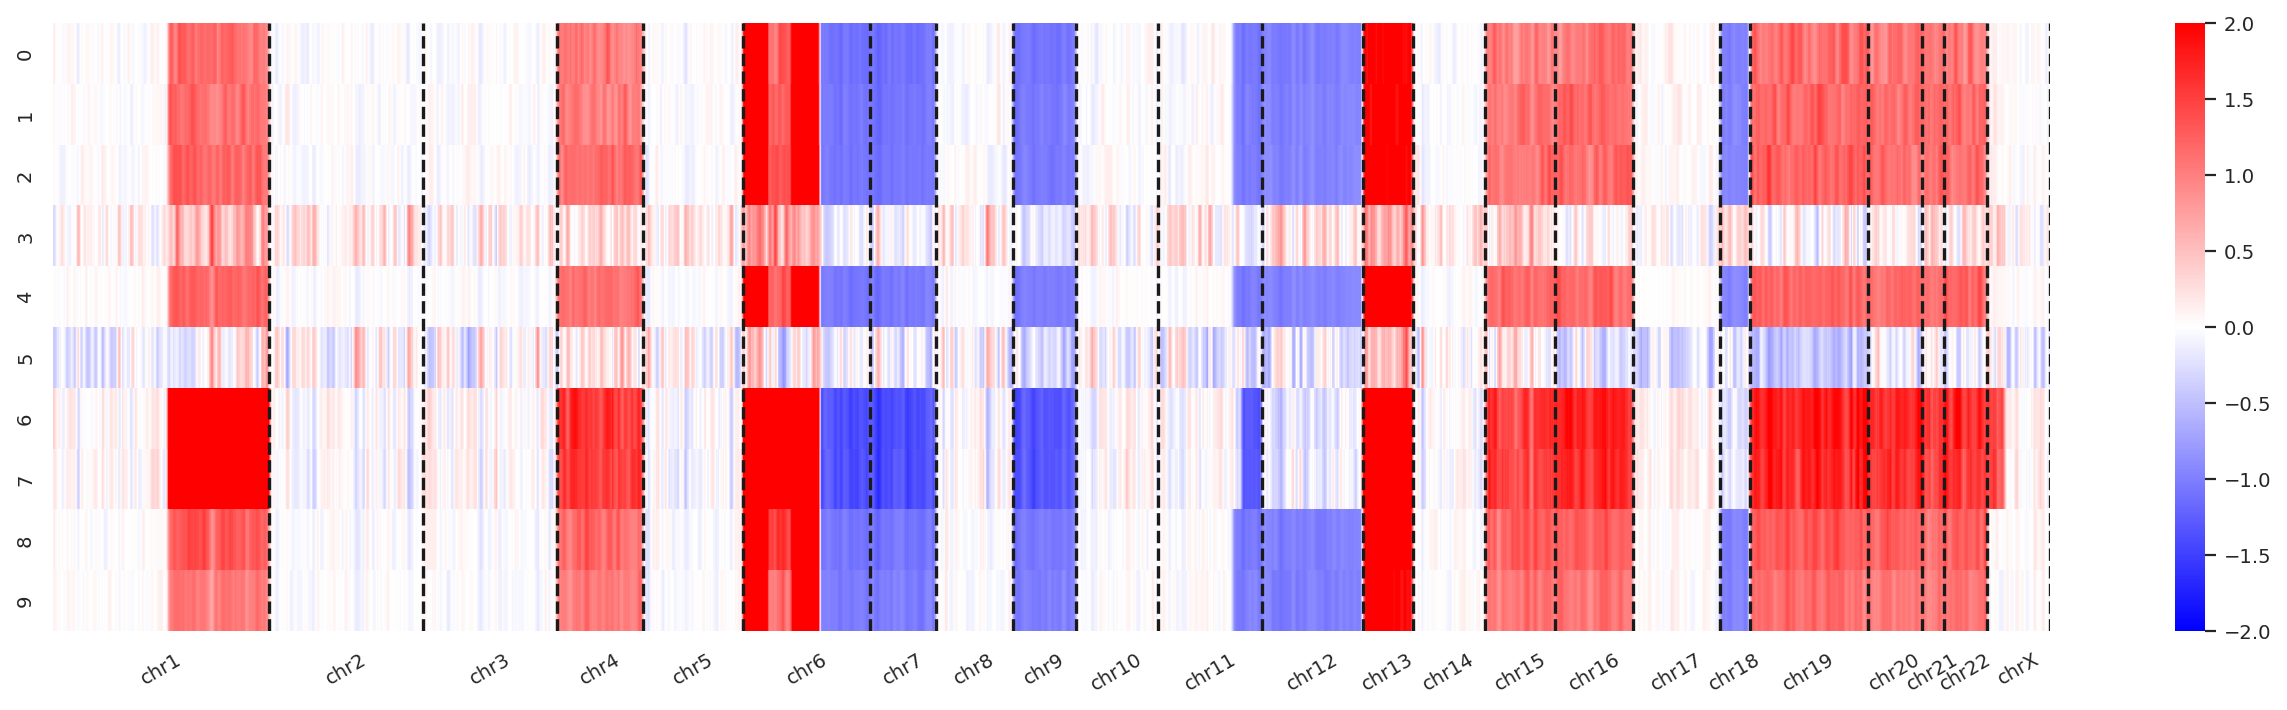

In [5]:
ec.pl.plot_cnv(adata)

The underlying results can be fetched from the `adata` object:

In [6]:
ec.tl.cnv_results(adata)

,geneName,chrom,echidna_clone_0,echidna_clone_1,echidna_clone_2,echidna_clone_3,echidna_clone_4,echidna_clone_5,echidna_clone_6,echidna_clone_7,...,states_echidna_clone_0,states_echidna_clone_1,states_echidna_clone_2,states_echidna_clone_3,states_echidna_clone_4,states_echidna_clone_5,states_echidna_clone_6,states_echidna_clone_7,states_echidna_clone_8,states_echidna_clone_9
0,AGRN,chr1,2.236076,2.121764,2.082903,1.181884,2.023187,1.322542,2.615338,2.461498,...,neut,neut,neut,del,neut,del,neut,neut,neut,neut
1,C1orf159,chr1,2.251200,2.128334,2.081373,1.160889,2.032540,1.287936,2.619271,2.484982,...,neut,neut,neut,del,neut,del,neut,neut,neut,neut
2,SDF4,chr1,2.234218,2.113961,2.088318,1.159172,2.046299,1.306351,2.611928,2.479578,...,neut,neut,neut,del,neut,del,neut,neut,neut,neut
3,B3GALT6,chr1,2.227667,2.095244,2.075394,1.178927,2.049225,1.310371,2.595644,2.471345,...,neut,neut,neut,del,neut,del,neut,neut,neut,neut
4,UBE2J2,chr1,2.218838,2.088999,2.078969,1.189726,2.054025,1.305846,2.571937,2.475876,...,neut,neut,neut,del,neut,del,neut,neut,neut,neut
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6996,TMEM185A,chrX,2.095119,2.005172,2.063772,1.586728,2.008012,1.605015,2.279461,2.262558,...,neut,neut,neut,amp,neut,neut,neut,neut,neut,neut
6997,MAMLD1,chrX,2.142547,2.035327,2.079884,1.489338,2.048086,1.494836,2.352465,2.349050,...,neut,neut,neut,neut,neut,del,neut,neut,neut,neut
6998,MTM1,chrX,2.154923,2.041889,2.064863,1.501294,2.059365,1.481420,2.350282,2.345086,...,neut,neut,neut,neut,neut,del,neut,neut,neut,neut
6999,MTMR1,chrX,2.161033,2.050644,2.073295,1.461722,2.067604,1.452139,2.390168,2.377525,...,neut,neut,neut,neut,neut,del,neut,neut,neut,neut


Let's now look at the effect of deconvolved copy number variation and gene "dosage" effect. Given deletion or amplification of copy number in any given Echidna cluster, we can calculate the expected phenotypic impact as measured by $c$ which translates deconvolved copy number to observed expressions of RNA at the cellular level.

In [7]:
ec.tl.gene_dosage_effect(adata)

2024-10-19 05:16:11,840 | INFO : Added `.uns['echidna']['save_data']['gene_dosage']` : Path to gene dosage effect results.


In the function below, we can pass a list of `clusters` and `timepoints` to look at. **In the default, all clusters and all timepoints will be shown.** The `quantile` parameter filters for the highest varying genes in the top specified quantile. You can also choose to manually set a threshold variance wiht `var_threshold`.

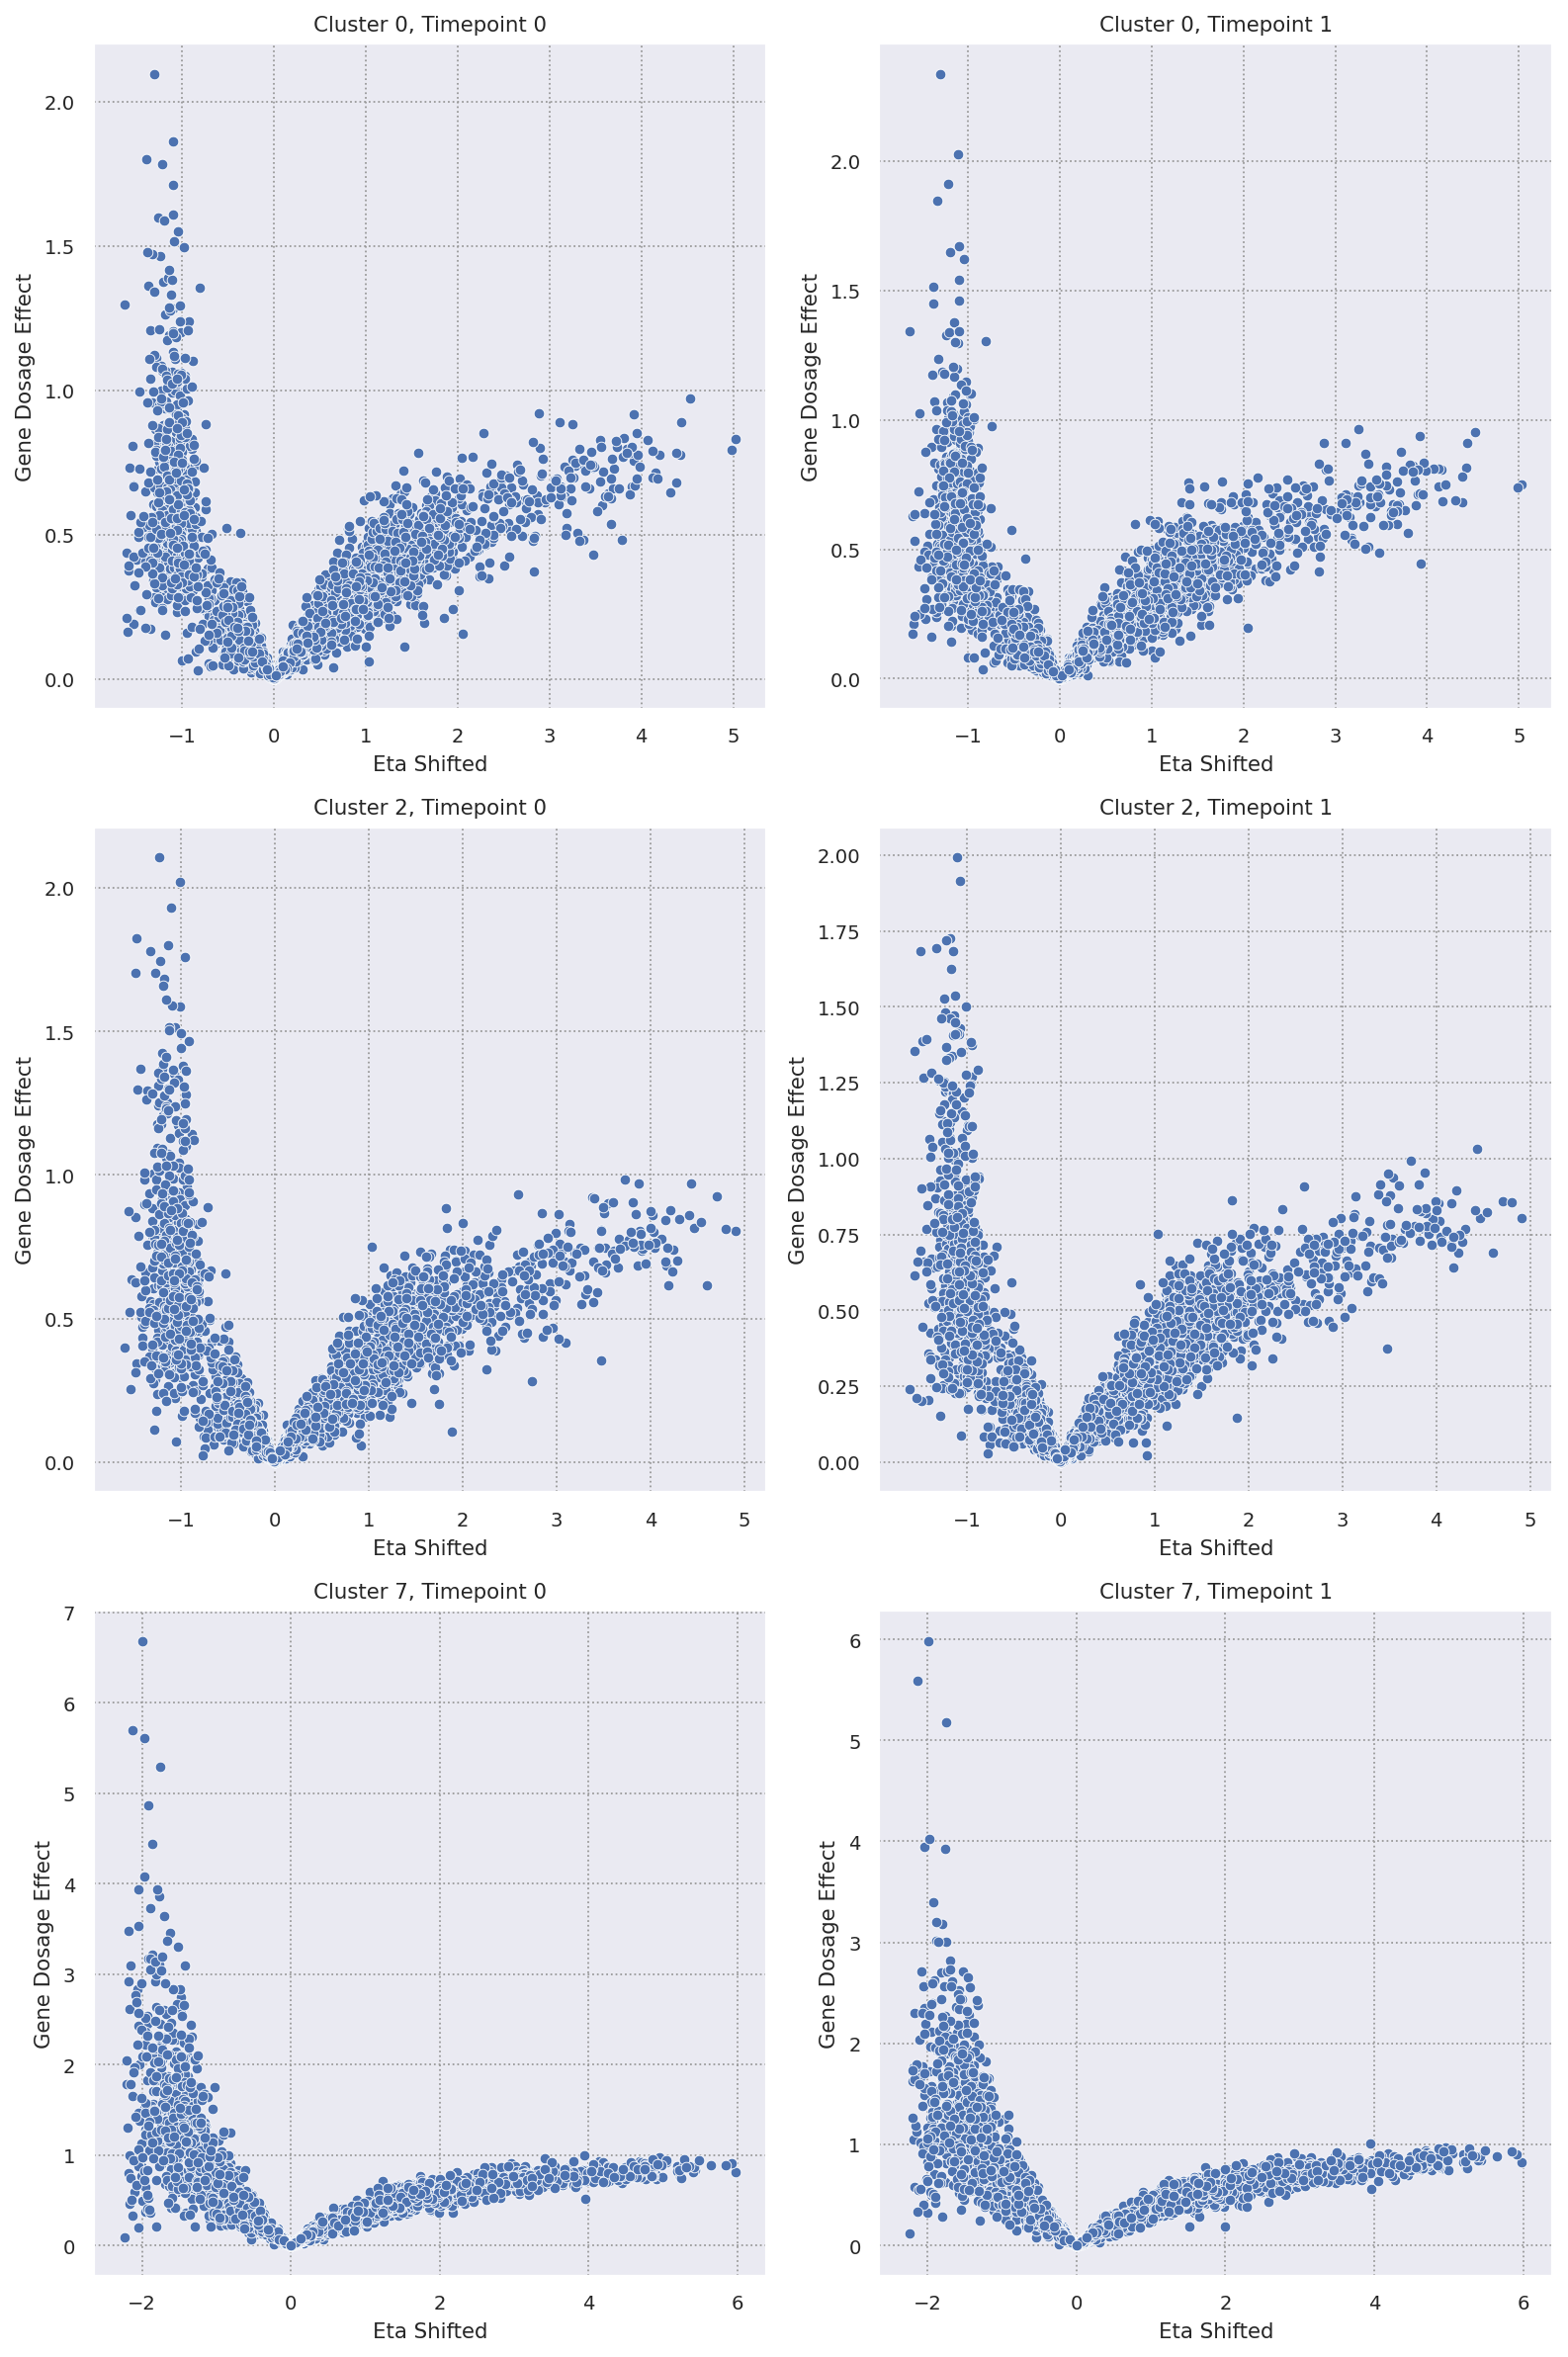

In [8]:
ec.pl.plot_gene_dosage(
    adata, clusters=[0,2,7], timepoints=[0,1], quantile=.8
)

### Using your own genome

In [9]:
import pandas as pd

This dataset is from the UCSC hg38 database. You can use any genome you prefer, as long as they are labeled with columns in the list below. Echidna uses these columns in `ec.tl.infer_cnv`:
`["chrom", "txStart", "txEnd", "geneName"]`.

In [10]:
genome = pd.read_csv(
    "https://hgdownload.soe.ucsc.edu/goldenPath/hg38/database/wgEncodeGencodeCompV46.txt.gz",
    delimiter="\t",
    header=None,
    names=["gene_id", "transcript_id", "chrom", "strand", "txStart", "txEnd", "cdsStart", "cdsEnd", "exonCount", "exonStarts", "exonEnds", "score", "geneName", "cdsStartStat", "cdsEndStat", "exonFrames"],
)
genome = genome.groupby(["chrom", "geneName"]).agg(
    txStart=("txStart", "min"),
    txEnd=("txEnd", "max")
).reset_index()

`ec.tl.infer_cnv` accepts kwargs to specify hyperparameters for the Gaussian HMM, as well parameters to designate the neutral CN value and the p-value threshold of the t-test to include a state in neutral classification.

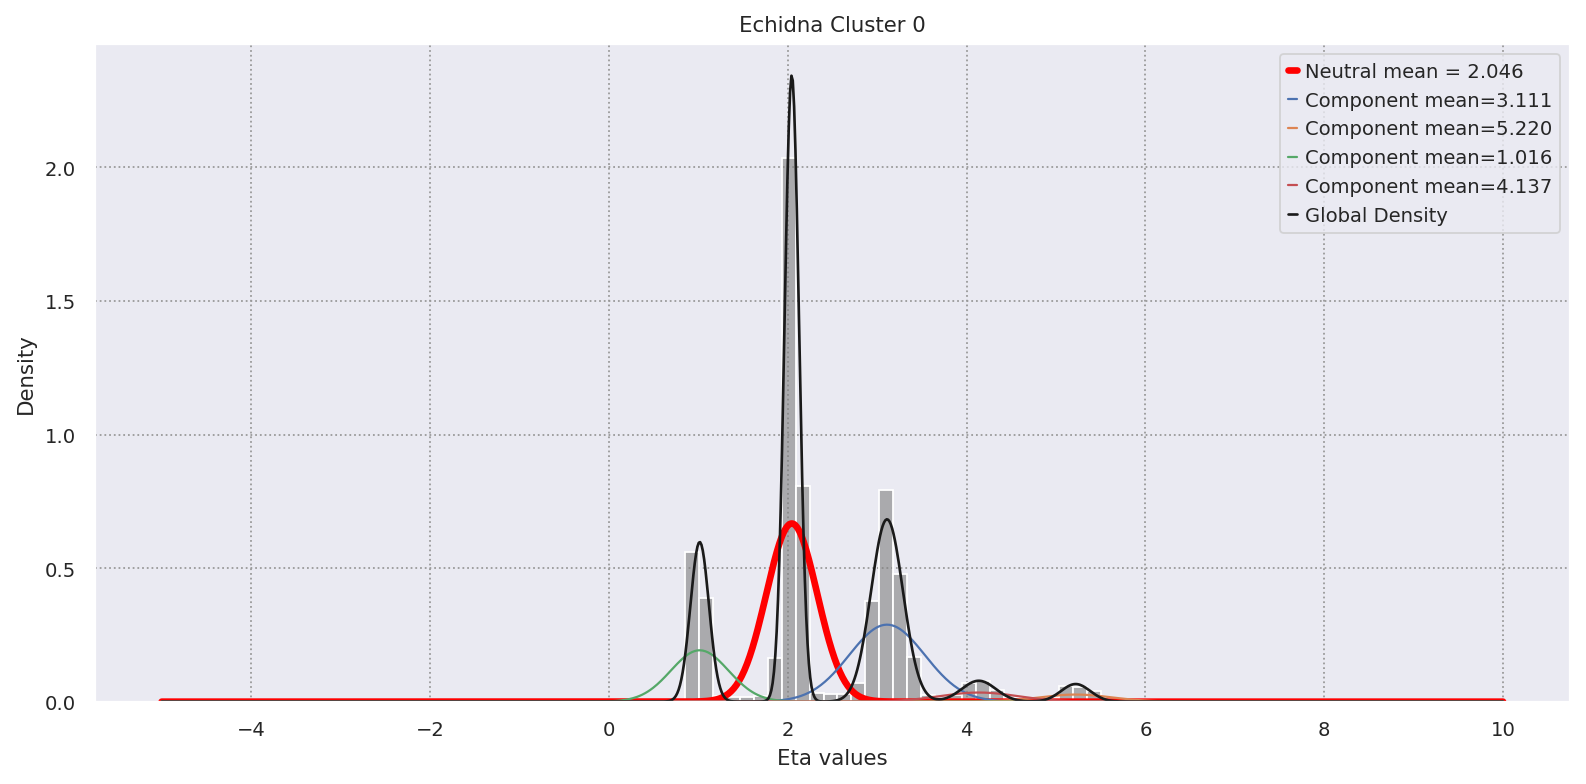

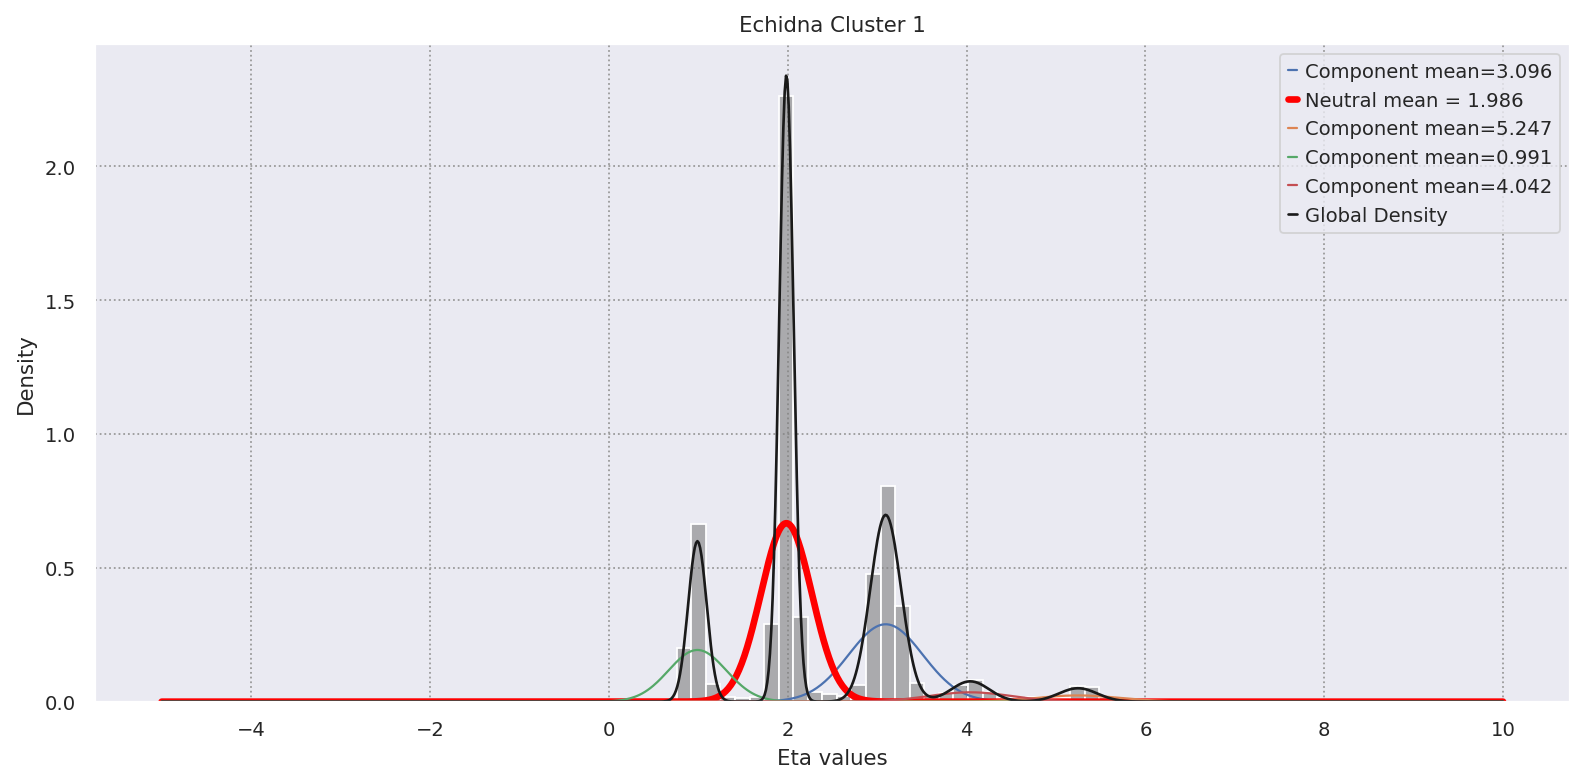

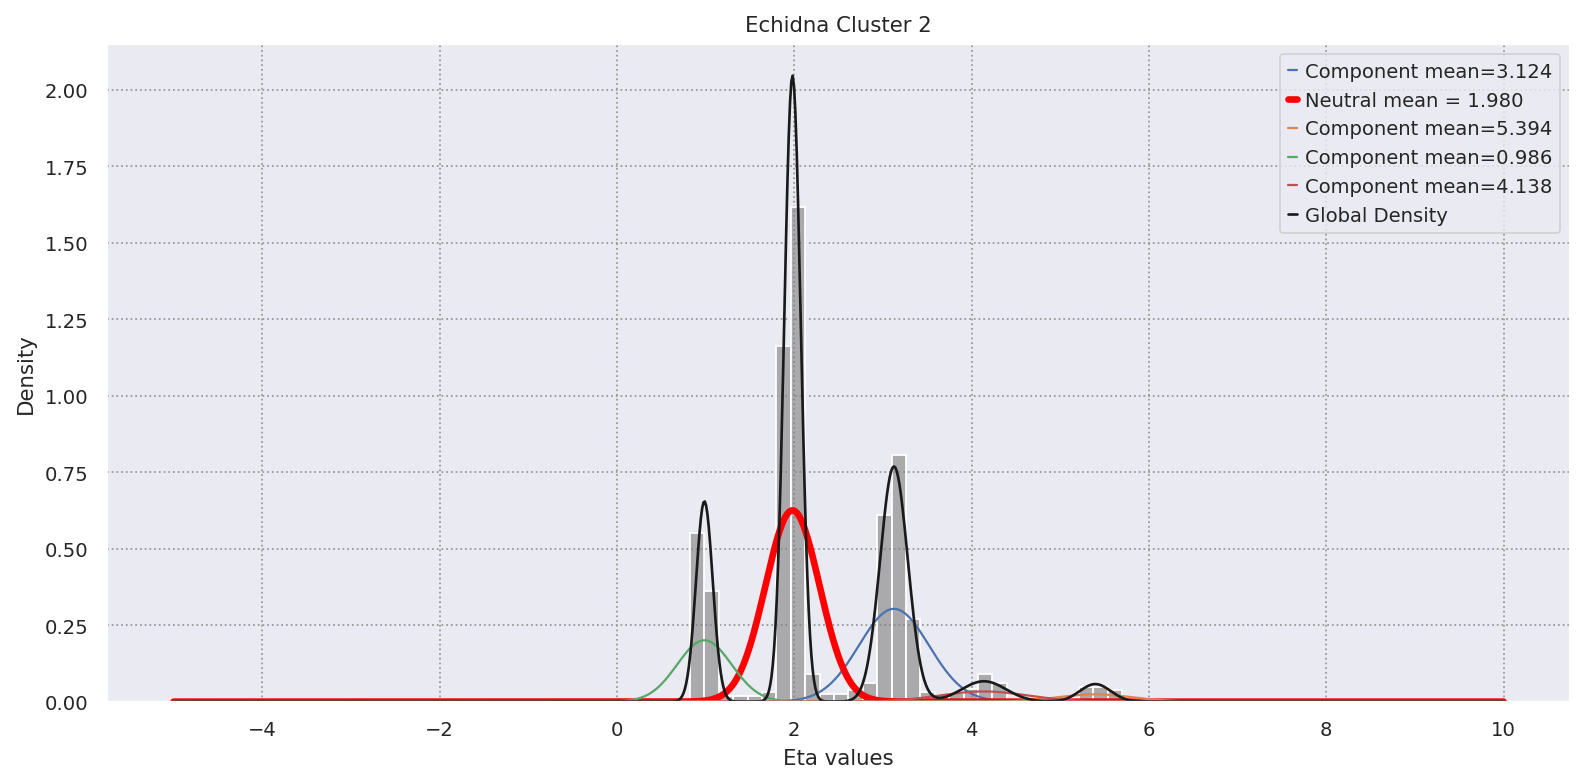

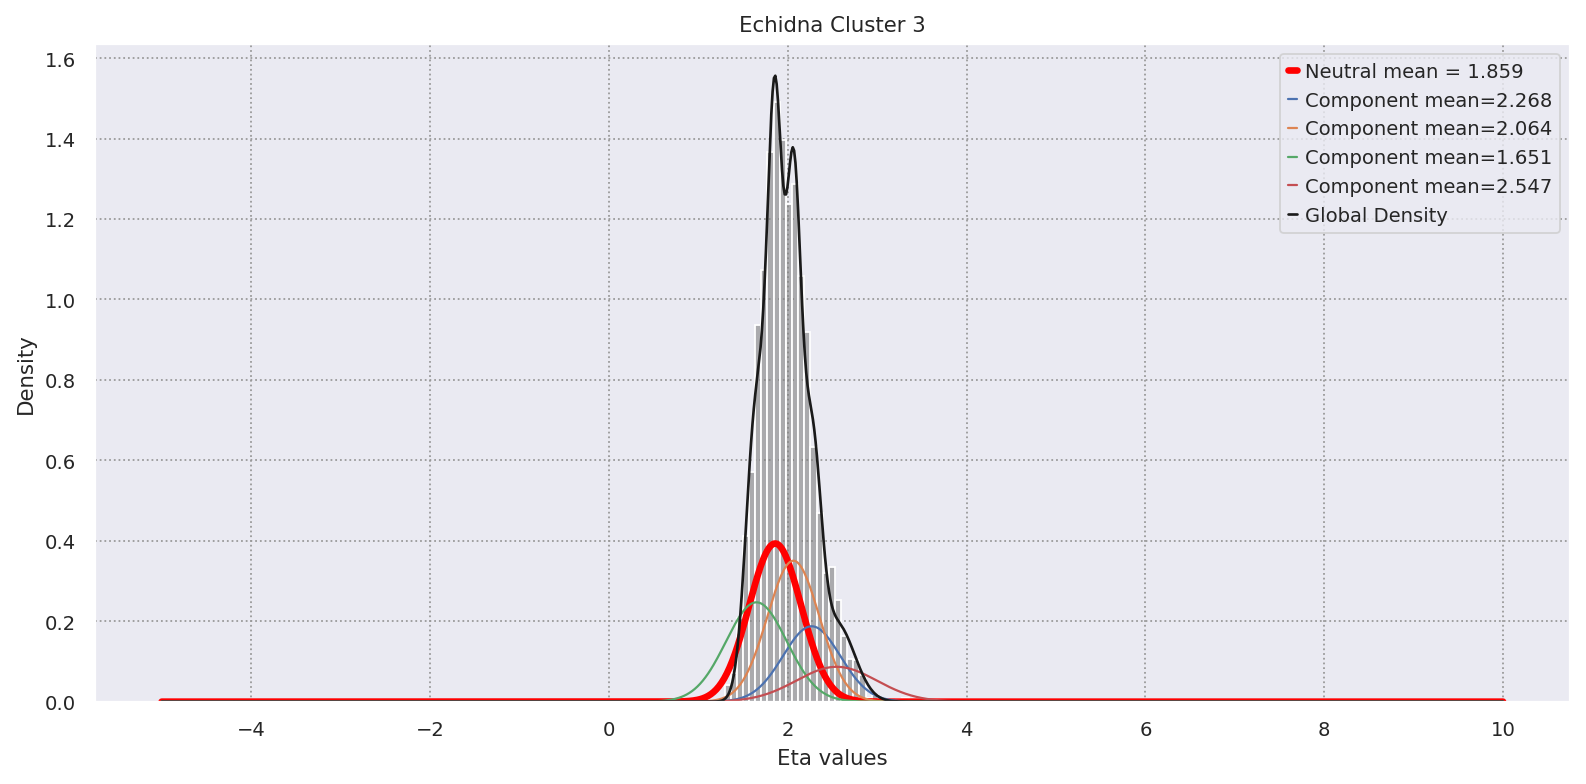

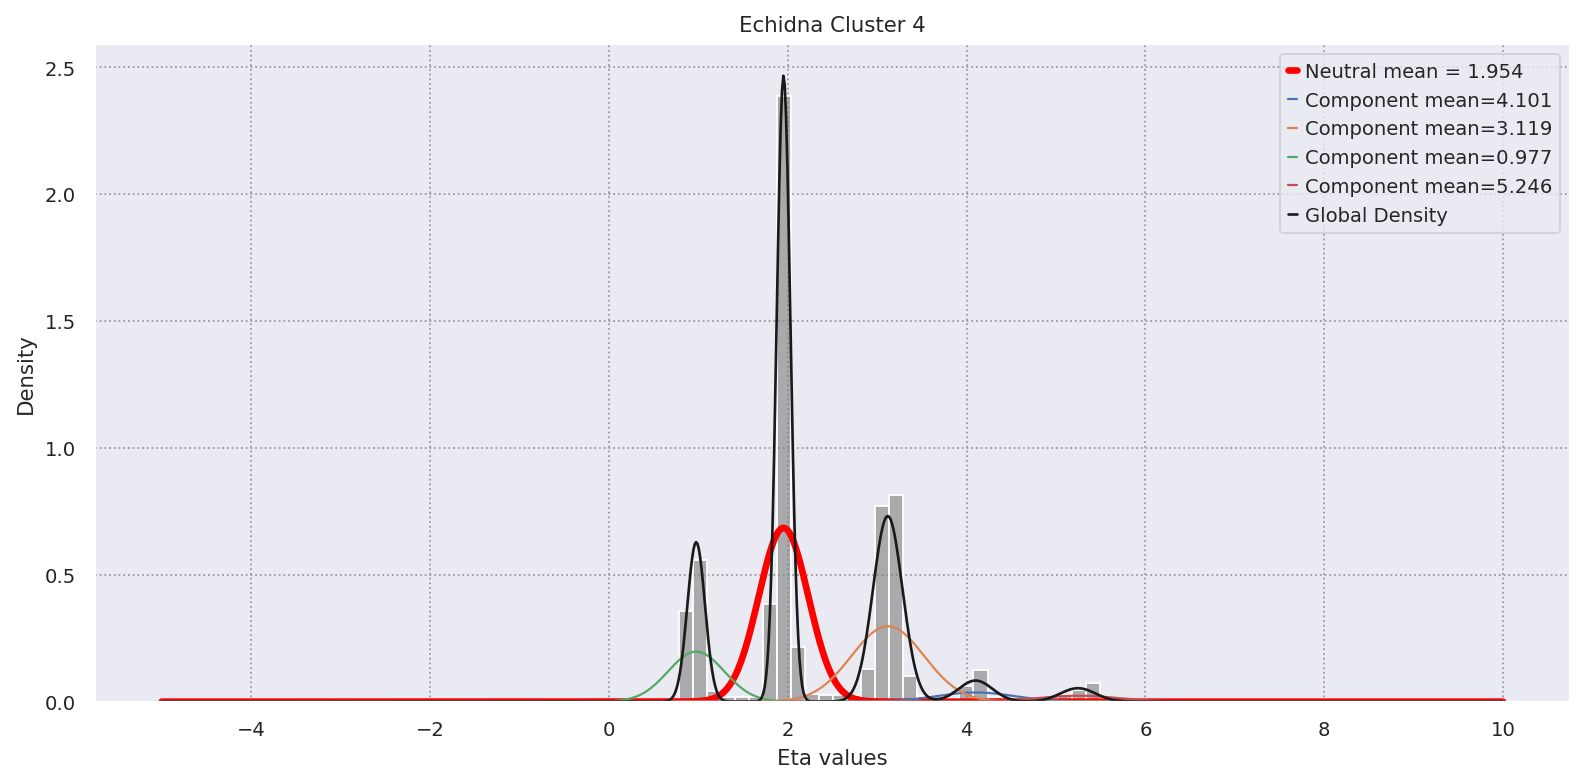

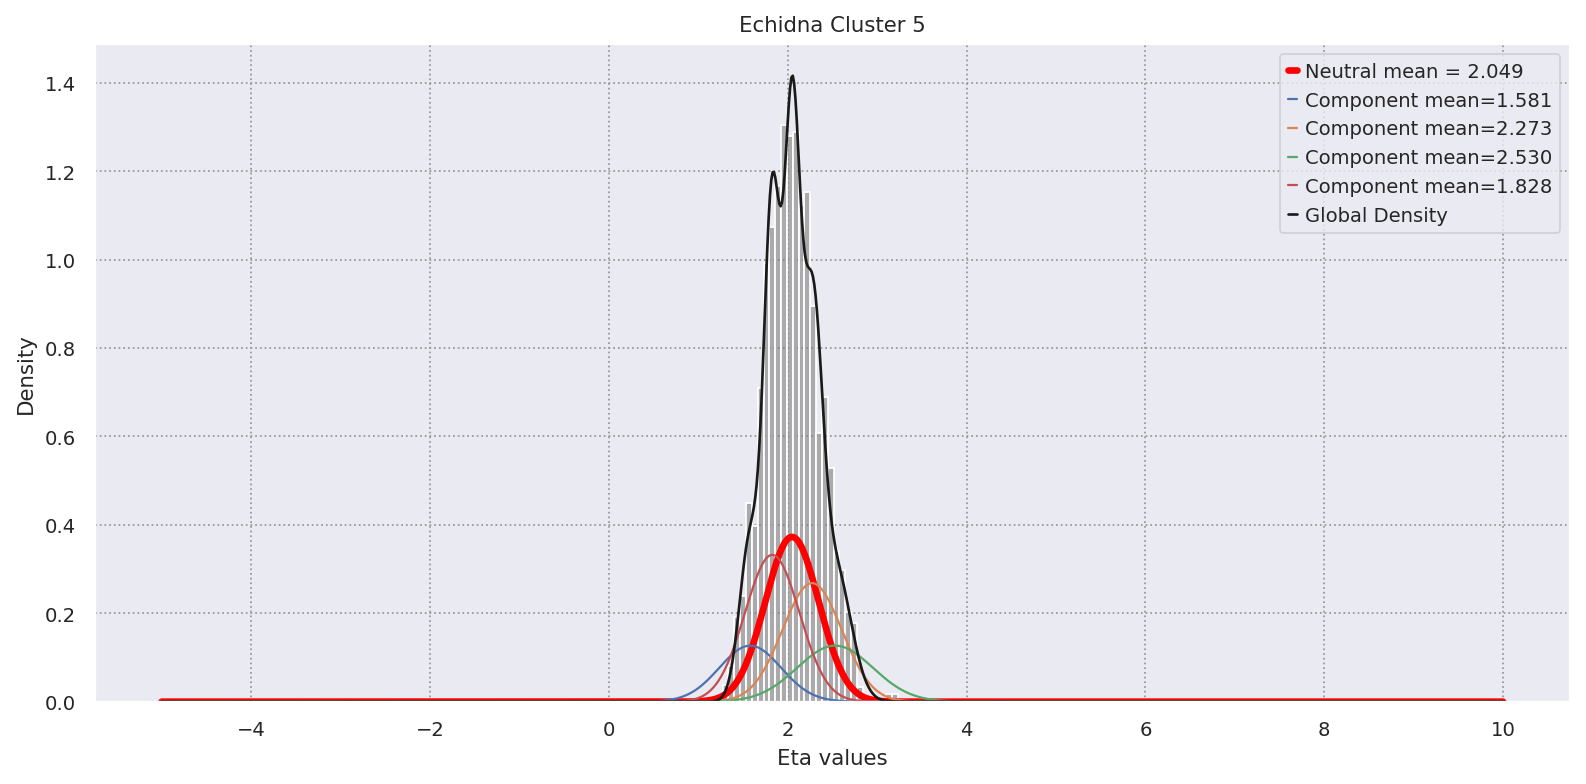

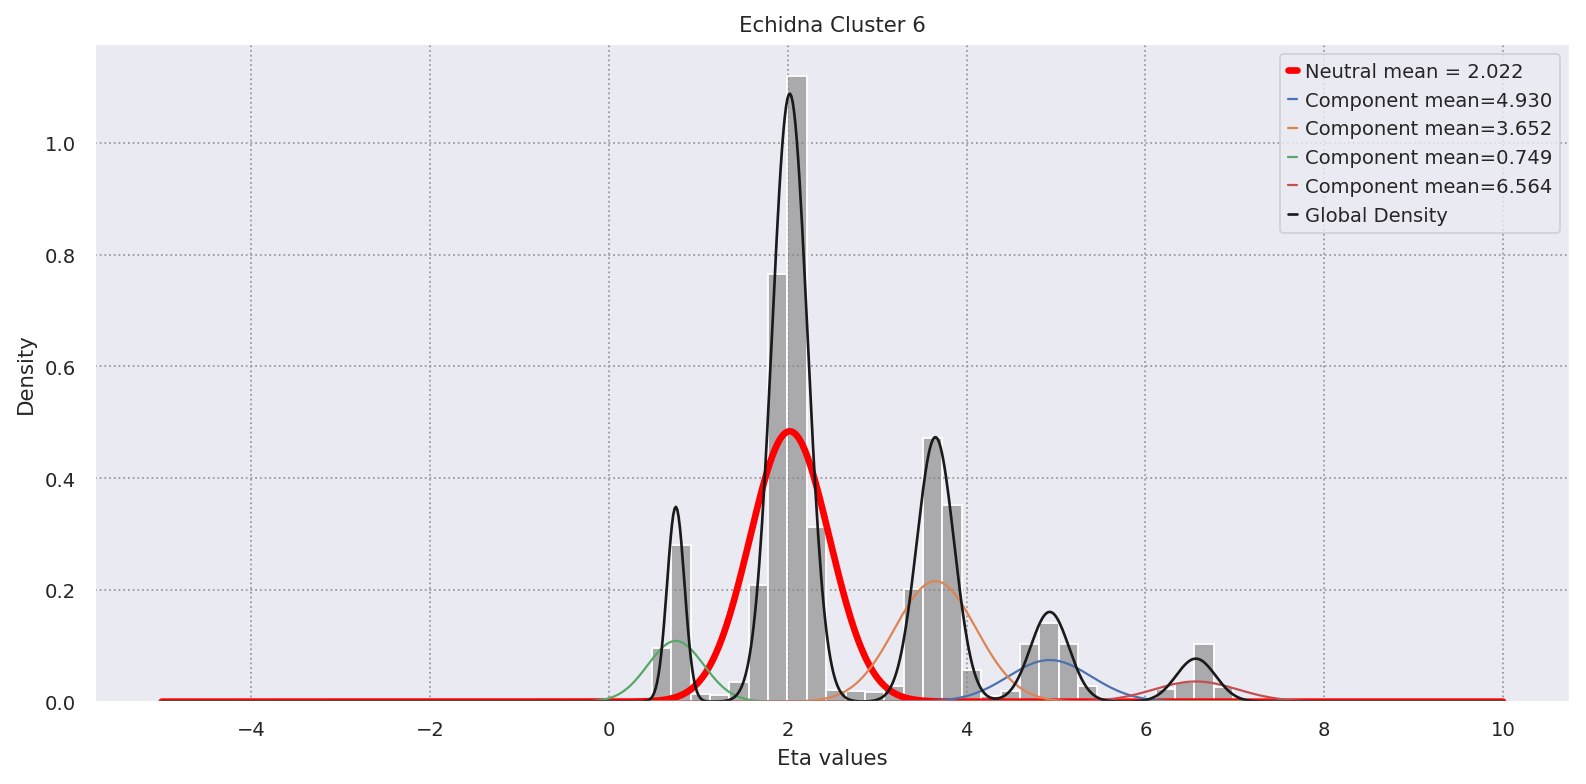

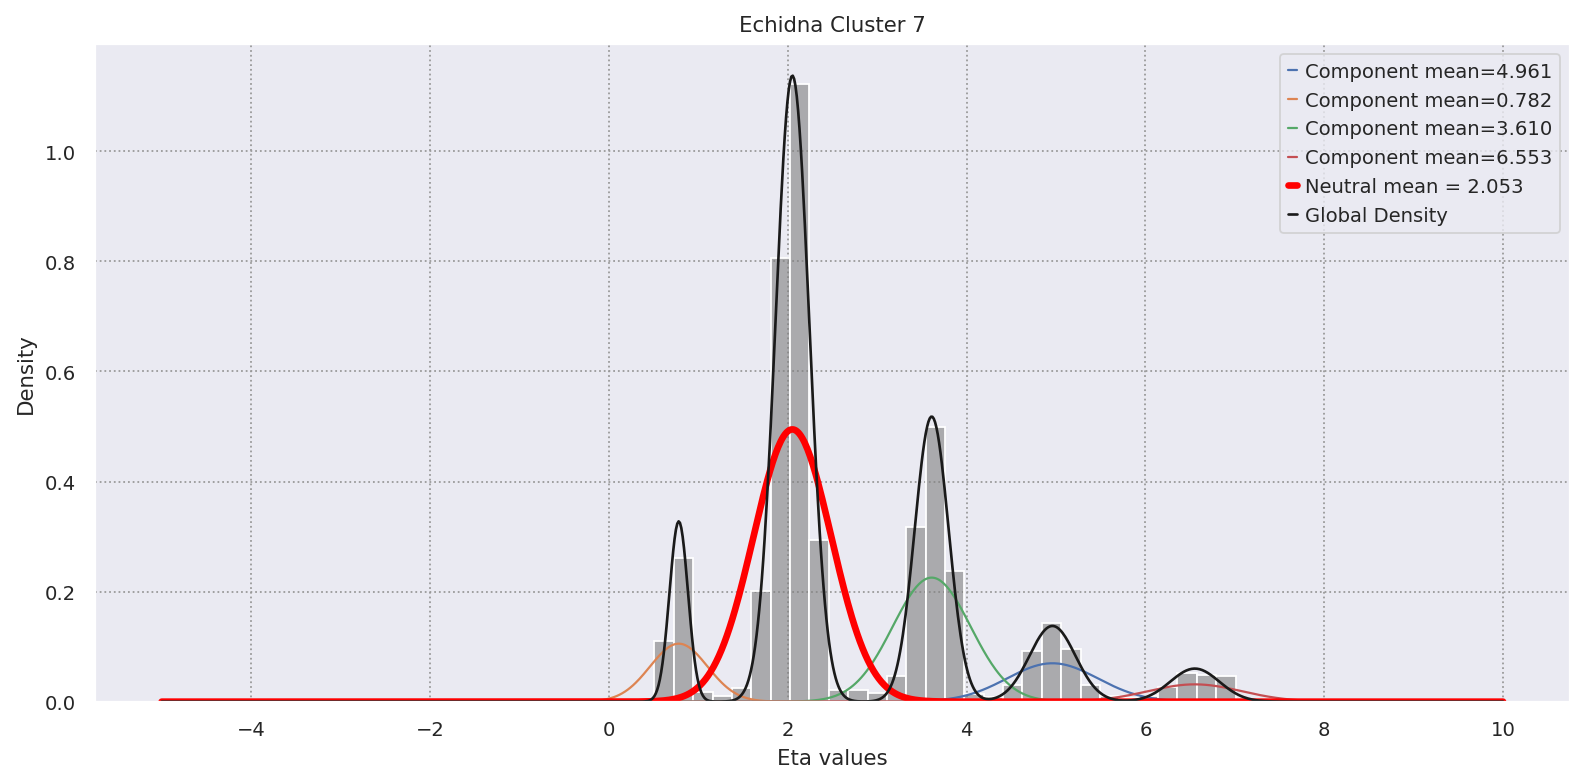

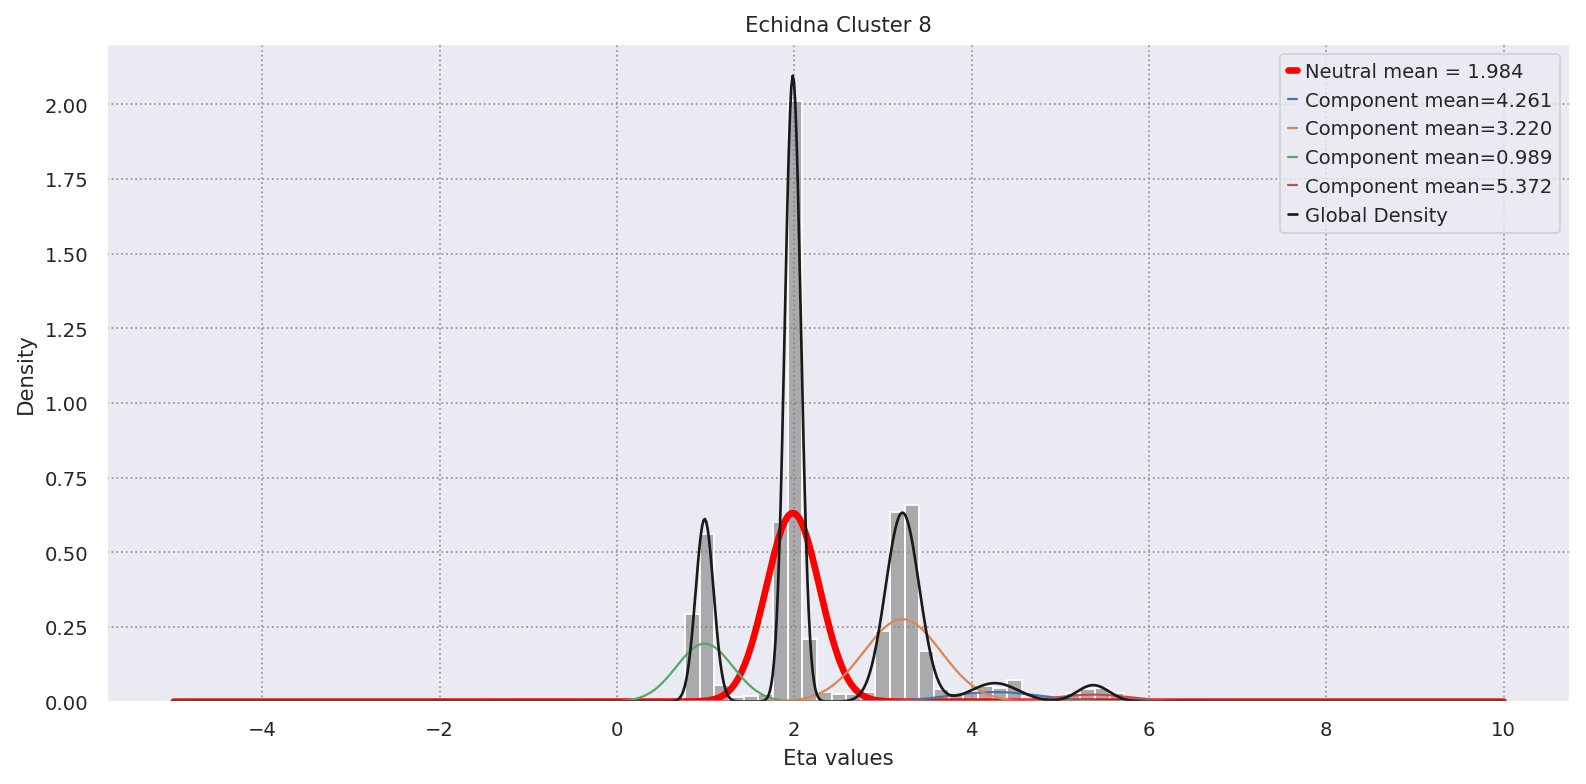

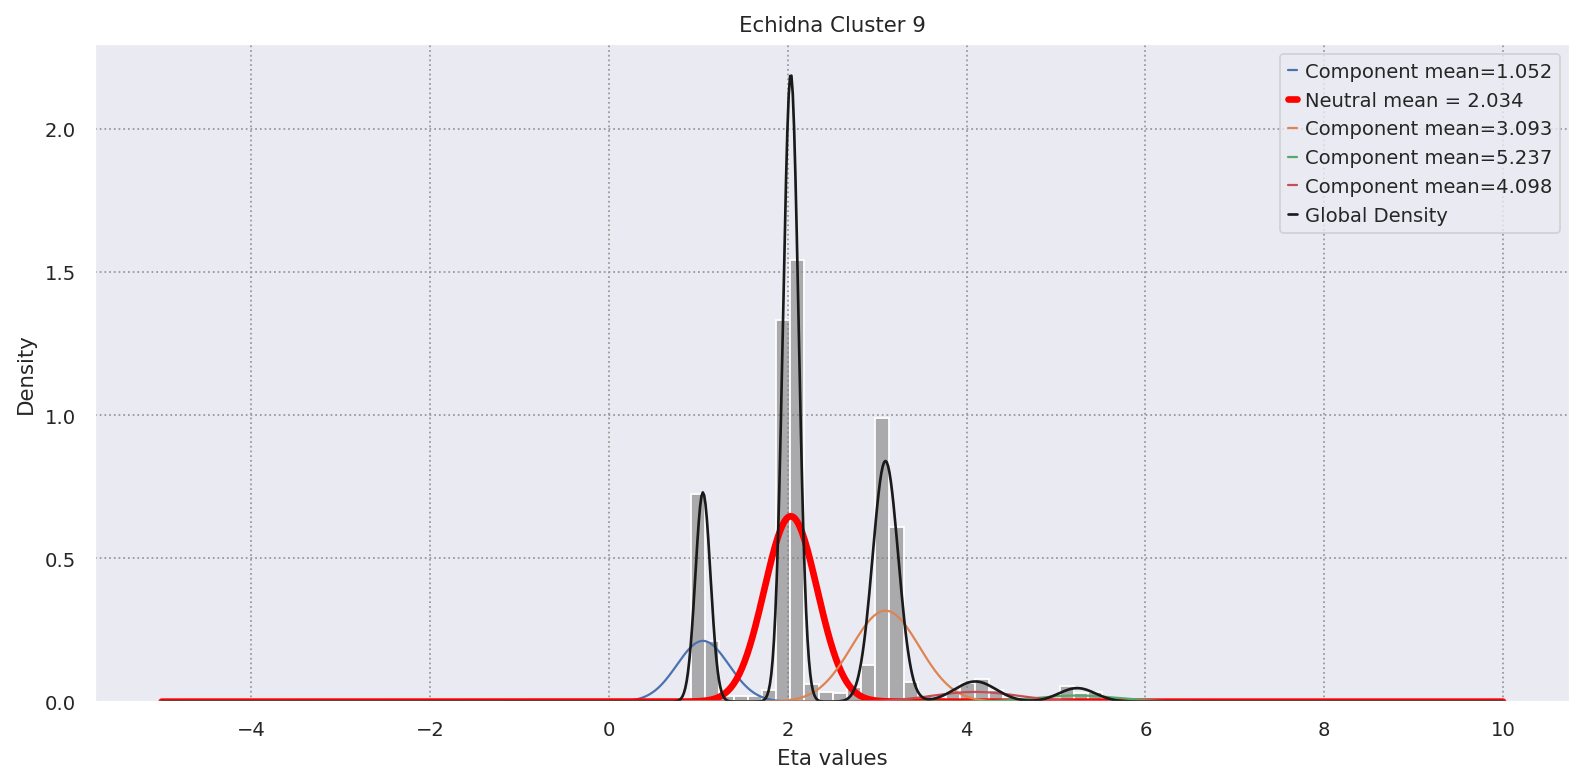

2024-10-19 05:18:14,116 | INFO : Added `.uns['echidna']['save_data']['infer_cnv']` : Path to CNV inference results.
Added `.uns['echidna']['save_data']['gmm_neutrals']` : Path to Echidna cluster neutral value results.


In [11]:
ec.tl.infer_cnv(
    adata,
    genome=genome, # custom genome
    gaussian_smoothing=True, # Apply a Gaussian filter before running HMM
    filter_genes=True, # If True, keeps only high variance genes in top filter_quantile
    filter_quantile=.8, # Quantile of variance for gene filter
    n_iter=100,
    transmat_prior=1, # Parameters of the Dirichlet prior distribution for each row of the transition probabilities
    startprob_prior=1, # Parameters of the Dirichlet prior distribution for startprob_
    n_gmm_components=5, # Number of components for GMM to detect neutral state of cluster
    smoother_sigma=6, # Stddev for Gaussian kernel smoothing, ignored if gaussian_smoothing=False
    smoother_radius=8, # Radius of Gaussian kernel, ignored if gaussian_smoothing=False
    plot_gmm=True, # View GMM densities for each cluster
)

Echidna will fit multiple HMMs and select the best fit, so don't be too concerned if a handful of runs fail to converge. It could be an indicator that new hyperparameters are in order, though.

If we specify a cluster, `plot_cnv` will create a plot containing the amplifications/deletions of the given cluster. Any plot in Echinda can be saved if parameter `filename` is passed.

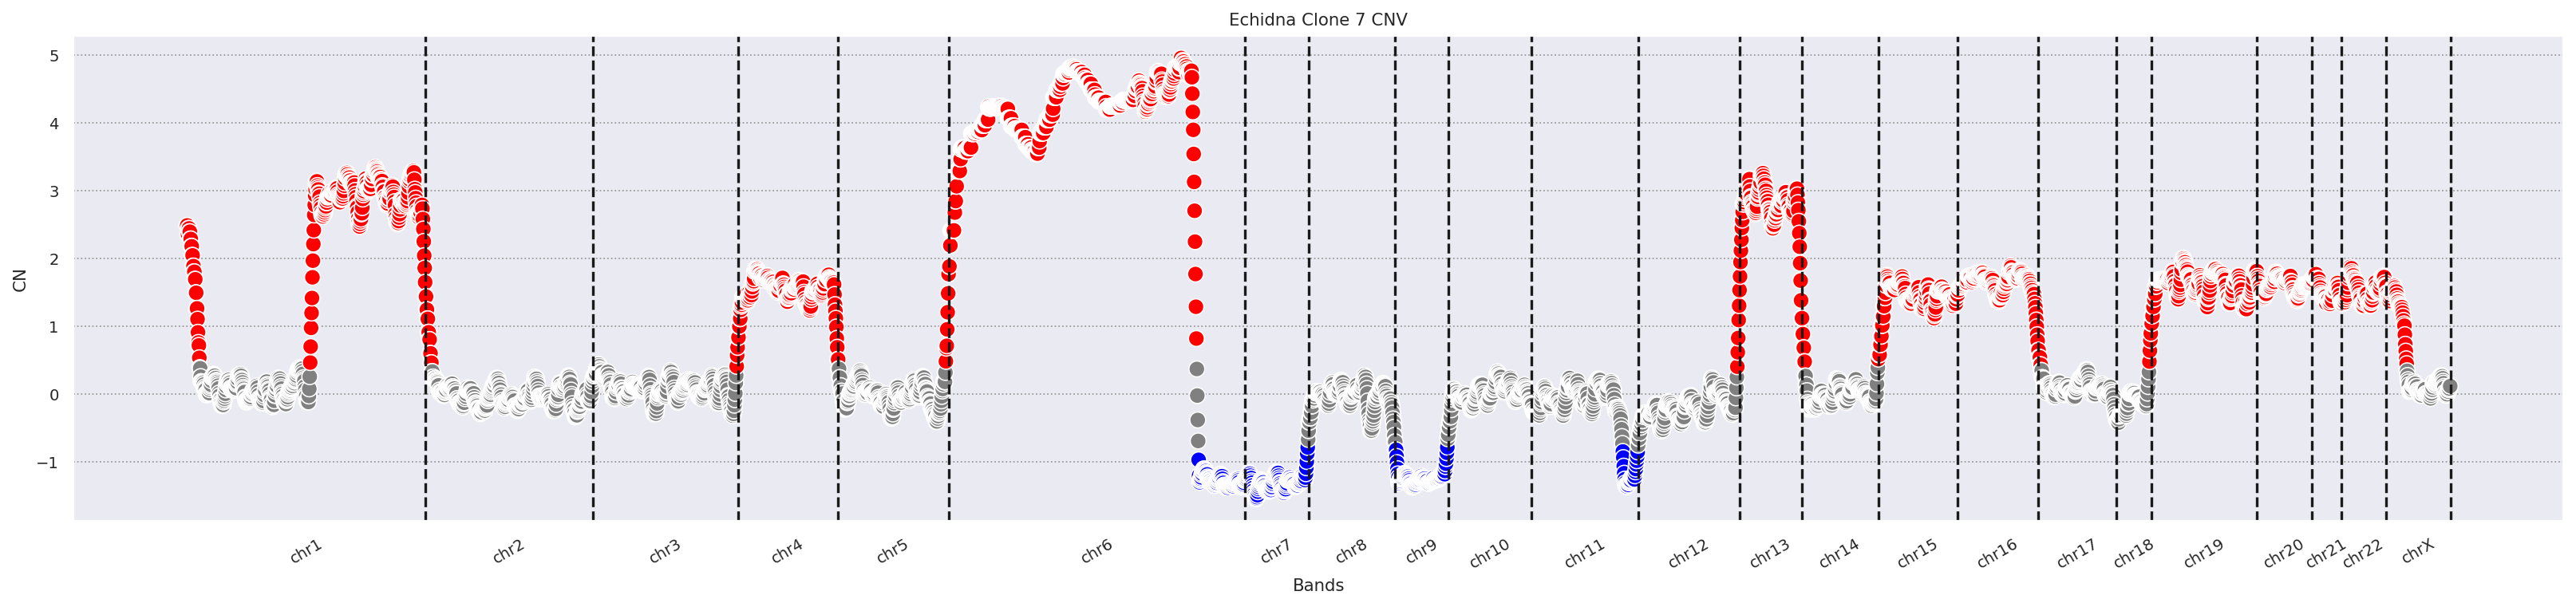

In [12]:
ec.pl.plot_cnv(adata, 7)